## Heuristic optimizations
There are multiple tweaks needed to get the final product working as desired. 

[Validation of pipeline](#section00)

[Simple penalty function](#section0)

[Exclusion of areas in Noord](#section1)

In [1]:
import sys
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely

sys.path.append("../")

from Code.helper_functions import initial_loading, analyze_candidate_solution,\
add_shortest_distances_to_all_households, calculate_weighted_distance, calculate_penalties,\
join_api_db, containers_per_cluster
from Code.loading_data import distance_matrix_with_counts, load_api_data,\
create_all_households, create_aansluitingen, load_geodata_containers, address_in_service_area
from Code.algorithms import clusterwise_optimization

POSTGRES password?WelkomCorne!


<a id='section00'></a>
## Validation of pipeline

There were a lot of small problems with the initial pipeline, which resulted in a need to validate all parts of this:
- amount of households per bag --> fixed
- total households --> fixed
- average walking distance update --> fixed
- Check amount of households in total --> fixed
- Exclude households that have more than 1000 meters walking distance --> fixed (optional parameter)


- locations
- Exclusion of some rural areas (Ransdorp, Durgerdam etc.)
- Penalties
- Search for rural areas and exclude those possibly


In [ ]:
rel_poi_df = pd.read_csv('../Data/postgres_db/info_pois.csv', index_col='Unnamed: 0')
rel_poi_df.head()
# rel_poi_df = rel_poi_df[['bk_afv_rel_nodes_poi','s1_afv_nodes', 's1_afv_poi', 'cluster_x', 'cluster_y', 'type', 'bag']]

In [ ]:
# rel_poi_df['bag'].value_counts()
# rel_poi_df[rel_poi_df['bag'] == '363100012241555']
# df = pd.read_csv('../Data/households_per_cluster.csv')
# df[df['ligtin_bag_pnd_identificatie'] == '0363100012241555']
info_poi = pd.read_csv('../Data/postgres_db/afv_poi.csv')
temp = rel_poi_df.groupby('bag').first().reset_index().rename(columns={0:'bag'})

In [ ]:
inpt_dfob = pd.read_csv('../Data/postgres_db/addresses_per_cluster.csv')
inpt_dis = pd.read_csv('../Data/postgres_db/distance_matrix.csv')

In [ ]:
df_afstandn2 = distance_matrix_with_counts(inpt_dfob=inpt_dfob,
                                                       inpt_poi=rel_poi_df,
                                                       inpt_dis=inpt_dis,
                                                       get_data=False)

In [ ]:
api_df = load_api_data(subsectie=None)

In [ ]:
all_households = create_all_households(rel_poi_df, subsectie=None)\
    .rename(columns={'s1_afv_nodes': 'naar_s1_afv_nodes'})

In [ ]:
joined = join_api_db(rel_poi_df, api_df)

In [ ]:
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], \
    joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie']
                                              .apply(lambda x:
                                              containers_per_cluster(x)))

In [ ]:
polygon_list = load_geodata_containers()
joined['move_rest'] = joined.apply(lambda row: address_in_service_area
                                   (row['cluster_x'], row['cluster_y'],
                                    polygon_list=polygon_list),
                                       axis=1)

In [ ]:
joined = joined[joined['totaal'] <= 8].reset_index()
joined = joined.drop(['index'], axis=1)

# joined

In [4]:
# automatic
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined


In [ ]:
# analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=False, use_count=True)
joined['rest'], joined['plastic'], joined['papier'], joined['glas'], \
    joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie']
                                              .apply(lambda x:
                                              containers_per_cluster(x)))

In [ ]:
# Check for validity

# df_afstandn2.groupby('naar_s1_afv_nodes').first()['count'].sum()
# joined[joined['move_rest'] == False]['stadsdeel'].value_counts()
# joined[joined['move_rest'] == False]['rest'].sum()

In [ ]:
joined_cluster_distance = joined.set_index('s1_afv_nodes')\
    .join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index()\
    .rename(columns={'index':'van_s1_afv_nodes'})

In [ ]:
good_result = add_shortest_distances_to_all_households(all_households,
                                                      joined_cluster_distance,
                                                      use_count=True)
good_result['rest_afstand'].isna().sum()

In [ ]:
good_result['count'] = good_result['count'].fillna(0)
good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] = good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']].fillna(999)
good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] = good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']].fillna(2000)


good_result.loc[~good_result['uses_container'],
                        'rest_afstand'] = np.nan
good_result.loc[~good_result['uses_container'], 'poi_rest'] = np.nan

good_result.loc[good_result['collect_cardboard'], 'papier_afstand'] = np.nan
good_result.loc[good_result['collect_cardboard'], 'poi_papier'] = np.nan

In [ ]:
aansluitingen = create_aansluitingen(good_result, joined_cluster_distance, use_count=True)

In [ ]:
(good_result['rest_afstand'] * good_result['count']).sum()/good_result['count'].sum()

In [ ]:
def calculate_weighted_distance(good_result, use_count=False, w_rest=0.61,
                                w_plas=0.089, w_papi=0.16, w_glas=0.11,
                                w_text=0.025, return_all=False):
    """
    Calculate weighted distance of an input dataframe.

    Function to calculated the weighted average walking distance as part of the
    score function. It calculates the mean difference per fraction and employs
    the weights assigned to them to combine it into a single score.

    Input:
    df_containing distance from all households to its nearest container
    per fraction (known as good_result)

    Output:
    float representing weighted average distance
    """
    if not use_count:
        rest_mean = good_result['rest_afstand'].mean()
        papier_mean = good_result['papier_afstand'].mean()
        glas_mean = good_result['glas_afstand'].mean()
        plastic_mean = good_result['plastic_afstand'].mean()
        textiel_mean = good_result['textiel_afstand'].mean()
    else:
        rest_mean = (good_result['rest_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        papier_mean = (good_result['papier_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        plastic_mean = (good_result['plastic_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        glas_mean = (good_result['glas_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()
        textiel_mean = (good_result['textiel_afstand'] * good_result['count'])\
            .sum() / good_result['count'].sum()

    if return_all:  # Return all individual mean distances (for analysis)
        return rest_mean, plastic_mean, papier_mean, glas_mean, textiel_mean

    # Multiply mean distance per fraction with its relative importance
    score = w_rest * rest_mean + w_plas * plastic_mean + w_papi * papier_mean + \
        w_glas * glas_mean + w_text * textiel_mean
    return score

In [ ]:
avg_distance = calculate_weighted_distance(good_result,
                                           use_count=True,
                                           return_all=True)
avg_distance


# Adress POIs die meer dan 1 fractie niet binnen 1 km hebben maar wel woonfunctie huizen hebben
bad_ones = good_result[(((good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] == 999.0).sum(axis=1) > 1) & (good_result['count'] > 0))]
good_result_clean = good_result[(((good_result[['poi_rest', 'poi_plastic', 'poi_papier', 'poi_glas', 'poi_textiel']] == 999.0).sum(axis=1) < 2) & (good_result['count'] > 0))]

avg_distance2 = calculate_weighted_distance(good_result_clean,
                                            use_count=True,
                                            return_all=True)
avg_distance2, avg_distance

In [ ]:
def calculate_simple_penalties(good_result, aansluitingen, use_count=True,
                               w_rest=0.61, w_plas=0.089, w_papi=0.16, w_glas=0.11,
                               w_text=0.025, use_weight=True, return_all=True):
    """
    Return simplified version of penalties.

    Simplified version of penalty function that gives total amount of
    penalties.
    """
    if use_count:
        penalty1 = good_result[good_result['rest_afstand'] > 100]['count'].sum()
        penalty2 = good_result[good_result['plastic_afstand'] > 150]['count'].sum()
        penalty3 = good_result[good_result['papier_afstand'] > 150]['count'].sum()
        penalty4 = good_result[good_result['glas_afstand'] > 150]['count'].sum()
        penalty5 = good_result[good_result['textiel_afstand'] > 150]['count'].sum()
    
    else:
        penalty1 = good_result[good_result['rest_afstand'] > 100].shape[0]
        penalty2 = good_result[good_result['plastic_afstand'] > 150].shape[0]
        penalty3 = good_result[good_result['papier_afstand'] > 150].shape[0]
        penalty4 = good_result[good_result['glas_afstand'] > 150].shape[0]
        penalty5 = good_result[good_result['textiel_afstand'] > 300].shape[0]

    temp = (aansluitingen['poi_rest'] - aansluitingen['rest'] * 100)
    penalty6 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_plastic'] - aansluitingen['plastic'] * 200)
    penalty7 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_papier'] - aansluitingen['papier'] * 200)
    penalty8 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_glas'] - aansluitingen['glas'] * 200)
    penalty9 = temp[temp > 0].sum()
    temp = (aansluitingen['poi_textiel'] - aansluitingen['textiel'] * 750)
    penalty10 = temp[temp > 0].sum()

    if use_weight:
        total = w_rest * (penalty1 + penalty6) + w_plas * (penalty2 + penalty7) +\
            w_papi * (penalty3 + penalty8) + w_glas * (penalty4 + penalty9) +\
            w_text * (penalty5 + penalty10)
        if return_all:
            return total, penalty1, penalty2, penalty3, penalty4, penalty5,\
                penalty6, penalty7, penalty8, penalty9, penalty10
        else:
            return total

    return penalty1+penalty2+penalty3+penalty4+penalty5+penalty6+penalty7 + \
        penalty8+penalty9+penalty10

def calculate_penalties(good_result, aansluitingen, use_count=False,
                        w_rest=0.61, w_plas=0.089, w_papi=0.16, w_glas=0.11,
                        w_text=0.025, return_all=False):
    """
    Calculate the amount of penalties based on described policies.

    This function calculates all the penalties associated with the candidate
    solution. It does this by calculating the number of times all constraints
    are violated and applies the weighing that is associated with all these
    violations. D_... contain the maximum allowed walking distance to a
    container of the specified fraction. P_... show the maximum amount of
    households connected to a container of the fraction specified.

    Input:
    dataframe good_result containing per adress or adress poi the distance
    to the nearest container for all fractions.
    dataframe connections containing for all clusters the amount of containers
    per fraction, the amount of people using these containers and percentage
    of occupancy compared to the norm

    Output:
    The sum of all different penalties as a single float
    """
    # Create dict containing max_dist, max_connection and weight per fraction
    fractions = {'rest': [100, 100, w_rest], 'plastic': [150, 200, w_plas],
                 'papier': [150, 200, w_papi], 'glas': [150, 200, w_glas],
                 'textiel': [200, 750, w_text]}
    MAX_PERC = 100  # To prevent magic numbers
    NORMAL = 1500  # Normalization factor to balance both types of penalties
    penalties = []  # This list will store all penalties
    for k, v in fractions.items():  # Per fraction
        # Filter data for all entries that violate maximal walking distance
        dist_pen = good_result[good_result[f'{k}_afstand'] > v[0]]
        # Filter data for all containers having to many households attached
        conn_pen = aansluitingen[aansluitingen[f'{k}_perc'] > MAX_PERC]
        if not use_count:
            # Average amount of meters over maximum limit
            penalties.append((dist_pen[f'{k}_afstand'] - v[0]).sum() /
                             good_result.shape[0] * v[2])
            # Ratio of amount of households over threshold (with normalization)
            penalties.append((conn_pen[f'poi_{k}'] - (conn_pen[k] * v[1]))
                             .sum() / good_result['count'].sum() * v[2] *
                             NORMAL)
        else:  # Use count column to weigh according to households
            penalties.append(((dist_pen[f'{k}_afstand'] - v[0]) *
                              dist_pen['count']).sum()/good_result['count']
                             .sum() * v[2])
            penalties.append((conn_pen[f'poi_{k}'] - (conn_pen[k] * v[1]))
                             .sum() / good_result['count'].sum() * v[2] *
                             NORMAL)
    if return_all:  # Return all contributing factors
        return penalties
    else:  # Return only the sum of the penalties
        return sum(penalties)

In [ ]:
calculate_penalties(good_result, aansluitingen, return_all=True)
# calculate_simple_penalties(good_result, aansluitingen, use_count=True, use_weight=True, return_all=True)

# good_result[good_result['plastic_afstand'] > 150]['count'].sum()

How many random iterations?10
How many iterations hillclimber?15
Do you want the results saved(True/False)?True
Do you want to only use a subset of data?False
Do you want to use addresses over clusters?True
Do you want to apply simulated annealing? (True/False)False
Optimize on (score/penalties)?penalties
What method (2-opt, dim Gaussian, Gaussian)?Gaussian
Do you want to use addresses instead of clusters?True
What stadsdeel do you want to make as a subsection(optional parameter)?
What is the maximum amount of containers in a cluster that is considered to be useful?8
Where to get db files(local/online)?local
DB relation POIs loaded


..\Code\loading_data.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ligtin_bag_pnd_identificatie'] = \
..\Code\loading_data.py:397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verblijfsobjecten['bag'] = verblijfsobjecten.loc[:, 'bag']\


distance matrix loaded
API data loaded
Table all households created
API and DB joined
containers per cluster determined
move_rest determined
Average distance is : 145.60275060511293
Penalties are: 86.3799485038471
Simple penalties are: 14672.342
Average distance is : 148.32086004634937
Penalties are: 92.24856305407427
Simple penalties are: 16798.66
Average distance is : 156.66044914053194
Penalties are: 99.61888911969037
Simple penalties are: 17425.108
Average distance is : 155.09743620175828
Penalties are: 100.58193885461681
Simple penalties are: 17572.079
Average distance is : 157.13677700664746
Penalties are: 98.83132892747298
Simple penalties are: 16825.184
Average distance is : 155.63842299643105
Penalties are: 96.58544370972541
Simple penalties are: 16552.875
Average distance is : 155.59116638050816
Penalties are: 99.69619564013499
Simple penalties are: 17404.7
Average distance is : 154.6237436009527
Penalties are: 97.98215712896344
Simple penalties are: 17451.703
Average distanc

Average distance is : 158.77811280650798
Penalties are: 85.87367597681344
Simple penalties are: 29705.428
85.87367597681344 85.26467221820418
Amount of clusters to change: 21
Average distance is : 159.24861283198032
Penalties are: 86.3575332194342
Simple penalties are: 29782.856
86.3575332194342 85.26467221820418
**************************************************************
Average distance is : 121.42581475777634
Penalties are: 55.25127566550307
Simple penalties are: 168382.25199999998
**************************************************************
Nfinished, moving on
Average distance is : 122.49909139867087
Penalties are: 46.786166246660635
Simple penalties are: 22317.405
Average distance is : 130.2237704148269
Penalties are: 54.17714235539562
Simple penalties are: 25757.784
Average distance is : 130.24610907784353
Penalties are: 54.42684278148181
Simple penalties are: 24224.867
Average distance is : 127.87151168138466
Penalties are: 51.41765385332039
Simple penalties are: 23157.169

Average distance is : 111.76488579156674
Penalties are: 48.36204485810228
Simple penalties are: 102827.867
48.36204485810228 48.44606670732935
Amount of clusters to change: 88
Average distance is : 111.8764489217116
Penalties are: 48.35427897059388
Simple penalties are: 102770.19200000001
48.35427897059388 48.36204485810228
Amount of clusters to change: 100
Average distance is : 112.02565219849276
Penalties are: 48.45349416797387
Simple penalties are: 103342.43
48.45349416797387 48.35427897059388
Amount of clusters to change: 88
Average distance is : 112.22175171764367
Penalties are: 48.80252227770316
Simple penalties are: 103325.453
48.80252227770316 48.35427897059388
Average distance is : 121.17318006183476
Penalties are: 55.02043550338898
Simple penalties are: 169314.63199999998


,cluster_x,cluster_y,s1_afv_nodes,s1_afv_poi,type,bag,aantal_per_fractie,volume_per_fractie,street_name,buurt,wijk,stadsdeel,rest,plastic,papier,glas,textiel,totaal,move_rest,rest_threshold
0,124549,481681,863418.0,156928.0,afval_cluster,124549.098|481681.498,[Rest:1],[Rest:5 m3],Alexander Dumaslaan,T93a,T93,T,1,0,0,0,0,1,True,0.0
1,124562,481606,594399.0,24108.0,afval_cluster,124562.398|481605.919,"[Glas:1, Papier:1]","[Glas:5 m3, Papier:5 m3]",Alexander Dumaslaan,T93a,T93,T,0,0,1,1,0,2,True,0.0
2,124599,481768,625308.0,150701.0,afval_cluster,124599.009|481768.428,[Rest:1],[Rest:5 m3],Alexander Dumaslaan,T93a,T93,T,1,0,0,0,0,1,True,0.0
3,124614,481406,551412.0,35258.0,afval_cluster,124614.479|481405.698,[Rest:1],[Rest:5 m3],Boris Pasternakstraat,T93a,T93,T,1,0,0,0,0,1,True,0.0
4,124626,481633,579957.0,139758.0,afval_cluster,124625.600|481632.678,"[Rest:1, Glas:1, Plastic:1]","[Rest:5 m3, Glas:5 m3, Plastic:5 m3]",Agatha Christiesingel,T93a,T93,T,1,1,0,1,0,3,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5422,119362,485904,765250.0,33090.0,afval_cluster,119361.948|485904.050,"[Rest:1, Textiel:1]","[Rest:5 m3, Textiel:5 m3]",Overtoom,E21b,E21,E,1,0,0,1,0,2,True,999.0
5423,119303,482049,841418.0,44574.0,afval_cluster,119302.590|482049.249,[Rest:2],[Rest:8 m3],Soetendaal,K90d,K90,K,1,1,0,0,0,2,True,999.0
5424,119185,484269,930405.0,100725.0,afval_cluster,119184.838|484268.793,[Rest:1],[Rest:5 m3],Amazonenstraat,K48f,K48,K,1,0,0,0,0,1,True,999.0
5425,120710,482178,561477.0,37505.0,afval_cluster,120709.616|482178.098,[Rest:2],[Rest:8 m3],Tongelaer,K91c,K91,K,1,0,1,0,0,2,True,999.0


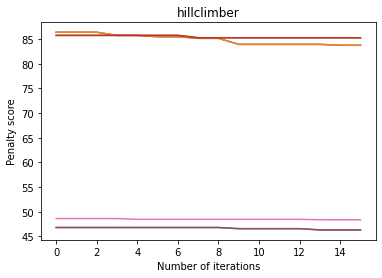

In [2]:
clusterwise_optimization()

### Find areas to exclude

In [3]:
# Identify extreme outliers

# Bad ones contributes to hosueholds that have 2 fractions not within 1000 meters
bad_ones = good_result[(((good_result[['poi_rest', 'poi_plastic',
                                                  'poi_papier', 'poi_glas',
                                                  'poi_textiel']] == 999.0)
                                  .sum(axis=1) > 1) & (good_result['count']
                                                       > 0))]

# Long is a group of households that has more than 1 fraction more than 750 meters away
long = good_result[(((good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] > 750)
                     .sum(axis=1) > 1) & good_result['count'] > 0)]

# Long2 is a group of households that has more than 2 fractions more than 750 meters away
long2 = good_result[(((good_result[['rest_afstand', 'plastic_afstand', 'papier_afstand', 'glas_afstand', 'textiel_afstand']] > 750)
                     .sum(axis=1) > 2) & good_result['count'] > 0)]

bad_ones.shape, long.shape, long2.shape

NameError: name 'good_result' is not defined

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool

load = gpd.read_file('../data/Inzameling_huisvuil_100220.shp')
street_map_clean = load[load['aanbiedwij'] ==
                              "Breng uw restafval  naar een container voor restafval."]
bewoonde_wijken = gpd.read_file('../data/woonbrt10_region.shp')
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')

geosource = GeoJSONDataSource(geojson=street_map_clean.to_json())
# geosource2 = GeoJSONDataSource(geojson=buurten.to_json())
geosource3 = GeoJSONDataSource(geojson=bewoonde_wijken.to_json())
geosource4 = GeoJSONDataSource(geojson=wijken.to_json())

source = ColumnDataSource(data=long)
source0 = ColumnDataSource(data=bad_ones)
source1= ColumnDataSource(data=long2)
source2 = ColumnDataSource(data=wijken)

TOOLTIPS2 = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Count", "@count")]

TOOLTIPS = [
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Naam", "@BCNAAM")]

p = figure(match_aspect=True)
p.patches('xs', 'ys', source=geosource, fill_color='grey', alpha=0.1, line_color=None)
p.patches('xs', 'ys', source=geosource3, fill_color='blue', alpha=0.1, line_color=None)
r0 = p.patches('xs', 'ys', source=geosource4, fill_color=None, alpha=0.1)
p.add_tools(HoverTool(renderers=[r0], tooltips=TOOLTIPS))

r1 = p.circle(x='cluster_x', y='cluster_y', source=source, radius=10, color='green')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))
r2 = p.circle(x='cluster_x', y='cluster_y', source=source0, radius=10, color='orange')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))
r1 = p.circle(x='cluster_x', y='cluster_y', source=source1, radius=10, color='red')
p.add_tools(HoverTool(renderers=[r1], tooltips=TOOLTIPS2))

show(p)

# long.plot(x='cluster_x', y='cluster_y', kind='scatter', s=0.1)

In [ ]:
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')
polygon_list = list(wijken.iloc[[49, 185, 307, 311, 328]]['geometry'])

import shapely
def address_in_service_area(x, y, polygon_list=None, subsectie=None):
    """
    Determine if a adress POI is within the specified service area.

    function to see whether a certain household is within the service area of
    rest. The test criterion is a shapefile containing all places in the city
    of Amsterdam.
    Input is x and y coordinates of a house and a list of polygons of service
    area. If polygon_list is not given, it is created within the function. This
    makes the function more dynamic, but providing polygon_list increases
    speed.
    Returns boolean
    """
    if polygon_list is None:
        pass
    point = shapely.geometry.Point(float(x), float(y))
    for polygon in polygon_list:
        if polygon.contains(point):
            return True
    return False

good_result.loc[good_result['collect_cardboard'], 'papier_afstand'] = np.nan
good_result.loc[good_result['collect_cardboard'], 'poi_papier'] = np.nan

In [ ]:
good_result[good_result['papier_afstand'].isna()]

In [ ]:
long2.iloc[65]

<a id='section1'></a>
### Exclusion of areas in North

In [ ]:
# Create dataframe noord holding only households in noord
noord = all_households[all_households['in_neigborhood']]

# Check which neigborhoods have no clusters
joined[joined['stadsdeel'] == 'N']['wijk'].value_counts()
joined_clean = joined[joined['stadsdeel'] == 'N']
joined_clean = joined_clean[joined_clean['wijk'] != 'N73']

# Load in shapefile of buurten to exclude N73, since N64 is in inhabited area
shapefile = gpd.read_file('../data/bc2010zw_region.shp')
Waterland = shapefile.iloc[69]['geometry']
Waterland

# Create column to check if addresses are in N73
noord['in_n73'] = noord.apply(lambda row: shapely.geometry.Point(row['cluster_x'], row['cluster_y']).within(Waterland), axis=1)
noord_clean = noord[~noord['in_n73']]

In [ ]:
joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined_clean, noord_clean, rel_poi_df, df_afstandn2, clean=False, use_count=True)

In [ ]:
joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined, noord, rel_poi_df, df_afstandn2, clean=False, use_count=True)

In [ ]:
good_result_rich[good_result_rich['rest_afstand'].isna()]

In [ ]:
all_households

In [ ]:
wijken = gpd.read_file('../data/brtk2010_ind2005_region.shp')
wijken['SD09'].value_counts()